In [1]:
import openai
openai.api_key = 'your key'  
model_name = 'gpt-3.5-turbo'#'text-davinci-002' # CaP uses text-davinci-002

class ChatGPT():
    def __init__ (self, system_prompt, model_engine='text-davinci-003'):
        self.model_engine = model_engine
        self.system_prompt = system_prompt
        self.msg_history_davinci = self.system_prompt
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]
        self.role = 'user'
    
    def reset(self):
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]

    def get_answer(self, prompt=None):
        if self.model_engine == 'gpt-3.5-turbo':
            self.msg_history_turbo.append({"role": self.role, "content":prompt})
            response   = openai.ChatCompletion.create(
            model      = self.model_engine,
            temperature= 0.0,
            messages   = self.msg_history_turbo)
            reply_text = response['choices'][0]['message']['content']
            self.msg_history_turbo.append({"role":"assistant", "content":reply_text})

        elif self.model_engine == 'text-davinci-003': 
            self.msg_history_davinci += "You: "+prompt 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = self.msg_history_davinci,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            #stop       = ["You:", "AI:"]
            )
            reply_text = response.choices[0].text.strip().replace('Answer: ', '')
            self.msg_history_davinci+="\n"+"AI: "+reply_text+"\n"

        elif self.model_engine == 'text-davinci-002': 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = prompt,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            )
            reply_text = response['choices'][0]['text'].strip()
        return reply_text



In [2]:
sys_prompt = """
We have a manipulator and we want you to help plan how it should move to perform tasks using the
following APIs:
    def end_effector_to(position_obj)
position_obj is a list of 3 float numbers [x,y,z]
    def end_effector_open()
Open the end effector
    def get_object_center_position(obj_name)
Given an object name, return a list of 3 float numbers [x,y,z] for the object position.
    def get_object_size(obj_name)
Given an object name, return a list of 3 float numbers [x,y,z] for the object size.
    def get_current_position()
Return a list of 3 float numbers [x,y,z] for the current position of the end effector.
    def normalize_table_position(position_obj)
Given a position, return a normalized position that is on the table.
    def denormalize_table_position(position_obj)
Given a normalized position, return a position that is on the table.
    def check_empty(position_obj)
Return True if the position is empty, False otherwise.

Example answer code:
    import numpy as np
    # place the object in the shelf_floor_1
    def place_object_row1():
        object_pos = get_object_center_position('shelf_row1')
        object_size = get_object_size('shelf_row1')
        range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
        for y in np.linspace(range_y[0], range_y[1], 10):
            target_pos = [object_pos[0], y, object_pos[2]]
            empty = check_empty(target_pos)
            if empty:
                end_effector_to(target_pos)
                end_effector_open()
                return
    place_object_row1()

    # place the object in the shelf_floor_2
    def place_object_row2():
        object_pos = get_object_center_position('shelf_row2')
        object_size = get_object_size('shelf_row2')
        range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
        for y in np.linspace(range_y[0], range_y[1], 10):
            target_pos = [object_pos[0], y, object_pos[2]]
            empty = check_empty(target_pos)
            if empty:
                end_effector_to(target_pos)
                end_effector_open()
                return
    place_object_row2()

    # place the object in the shelf_floor_3
    def place_object_row3():
        object_pos = get_object_center_position('shelf_row3')
        object_size = get_object_size('shelf_row3')
        range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
        for y in np.linspace(range_y[0], range_y[1], 10):
            target_pos = [object_pos[0], y, object_pos[2]]
            empty = check_empty(target_pos)
            if empty:
                end_effector_to(target_pos)
                end_effector_open()
                return
    place_object_row3()
        
    # place the object on the center of the table
    target_pos = [0, 0, 0]
    target_pos = denormalize_table_position(target_pos)
    end_effector_to(target_pos)
    end_effector_open()

Remember:
1. Always format the code in code blocks.
2. Do not invent new functions or classes. The only allowed functions you can call are the ones listed
above. Do not leave unimplemented code blocks in your response.
3. The only allowed library is numpy. Do not import or use any other library.
4. If you are not sure what value to use, just use your best judge. Do not use None for anything.
5. You do not need to make the robot do extra things not mentioned in the plan such as stopping the
robot.
6. Try your best to generate code despite the lack of context.
7. Only use end_effector_to, end_effector_open once in your code.
8. The 1-st of the bookshelf is full of books. There are three fragile wine glasses on 3-rd of the bookshelf. 
9. Tell me the executable code directly. Do not tell me the code in words.
"""
llm = ChatGPT(sys_prompt, model_engine=model_name)
llm.reset()


In [3]:
import mujoco#,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


In [4]:
xml_path = '../../../asset/scene_office_bookshelf.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,0.80,0])

jntadr_mug_cup = env.model.body('mug_cup').jntadr[0]
env.model.joint(jntadr_mug_cup).qpos0[:3] = np.array([0.5, -0.4, 0.81])
env.model.joint(jntadr_mug_cup).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, np.random.rand() * 360])))
env.model.body('shelf_row1').pos = np.array([0.8,0.3,0.75])
env.model.body('shelf_row1').quat = r2quat(rpy2r(np.radians([0, 0, 90])))

obj_box_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_box"))]
obj_wine_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_wine"))]
obj_book_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("book"))]

# Place objects
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)
n_wine_obj = 3
env.place_objects_random(n_obj=n_wine_obj, obj_names=obj_wine_names, x_range=[0.80, 0.85], y_range=[0.3, 0.5], z_range=[1.35,1.35], min_dist=0.05, COLORS=False, VERBOSE=True)

env.model.joint(env.model.body('starbucks_cup').jntadr[0]).qpos0[:3] = np.array([-8, 0.35, 1.5])
env.model.joint(env.model.body('mug_cup').jntadr[0]).qpos0[:3] = np.array([-8, 0.45, 1.55])

# Book1 is target_object
# np.linspace(0.15 )
env.model.joint(env.model.body('book2').jntadr[0]).qpos0[:3] = np.array([0.80, 0.42, 0.80])
env.model.joint(env.model.body('book3').jntadr[0]).qpos0[:3] = np.array([0.82, 0.39, 0.80])
env.model.joint(env.model.body('book4').jntadr[0]).qpos0[:3] = np.array([0.79, 0.27, 0.80])
env.model.joint(env.model.body('book5').jntadr[0]).qpos0[:3] = np.array([0.84, 0.17, 0.80])
env.model.joint(env.model.body('book6').jntadr[0]).qpos0[:3] = np.array([0.8, 0.13, 0.8])
env.model.joint(env.model.body('book7').jntadr[0]).qpos0[:3] = np.array([0.81, 0.23, 0.80])
env.model.joint(env.model.body('book8').jntadr[0]).qpos0[:3] = np.array([0.79, 0.30, 0.80])
env.model.joint(env.model.body('book9').jntadr[0]).qpos0[:3] = np.array([0.8, 0.35, 0.80])
env.model.joint(env.model.body('book10').jntadr[0]).qpos0[:3] = np.array([0.8, 0.47, 0.80])

env.model.joint(env.model.body('book1').jntadr[0]).qpos0[:3] = np.array([0.2, -0.4, 0.8])
env.model.joint(env.model.body('book1').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.array([1.57, 0, 0])))


window
obj_wine_01: [0.81 0.48 1.35]
obj_wine_02: [0.83 0.35 1.35]
obj_wine_03: [0.82 0.41 1.35]


In [5]:
shelf_poses = {
    'shelf_row1': np.array([0.8,0.3,0.81]),
    'shelf_row2': np.array([0.8,0.3,1.06]),
    'shelf_row3': np.array([0.8,0.3,1.32]),
}

In [6]:
object_info_dict = dict()
book_shelf_size = [0.243, 0.11, 0.005]
book_size = [0.03, 0.07, 0.11]
glass_size = [0.03, 0.03, 0.07]
table_size   = env.model.geom_aabb[env.model.body('avoiding_object_table').geomadr][0][3:]

object_info_dict['avoiding_object_table'] = {'name':"table", 'size': table_size, 'position': [0.38+0.45, 0., 0.8], 'rotation':[0., 0., 0.]}


In [7]:
object_info_dict

{'avoiding_object_table': {'name': 'table',
  'size': array([0.45, 0.6 , 0.37]),
  'position': [0.8300000000000001, 0.0, 0.8],
  'rotation': [0.0, 0.0, 0.0]}}

In [8]:
import math
def quat2r(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
        return roll_x, pitch_y, yaw_z

In [9]:
seen_obj_names = []
graphs = {}
THRES = [0.7, 1.0, 1.3]
env.step()
for body_name in env.body_names:
    if 'wine' in body_name:
        pos = env.model.joint(env.model.body(body_name).jntadr[0]).qpos0[:3]
        rot = env.model.joint(env.model.body(body_name).jntadr[0]).qpos0[3:]
        z_ = pos[2]
        if z_ < THRES[1]:
            graphs[body_name] = 'shelf_row1'
        elif z_ < THRES[2]:
            graphs[body_name] = 'shelf_row2'
        else: 
            graphs[body_name] = 'shelf_row3'
        seen_obj_names.append(body_name)
        object_info_dict[body_name] = {'name':"glass", 'size': glass_size, 'position': pos, 'rotation': quat2r(*rot)}
    elif 'book' in body_name:
        pos = env.model.joint(env.model.body(body_name).jntadr[0]).qpos0[:3]
        rot = env.model.joint(env.model.body(body_name).jntadr[0]).qpos0[3:]
        print(pos, body_name)
        z_ = pos[2]
        seen_obj_names.append(body_name)
        object_info_dict[body_name] = {'name':"book", 'size': book_size, 'position':pos, 'rotation':quat2r(*rot)}
        if body_name == 'book1': continue
        if z_ < THRES[1]:
            graphs[body_name] = 'shelf_row1'
        elif z_ < THRES[2]:
            graphs[body_name] = 'shelf_row2'
        else: 
            graphs[body_name] = 'shelf_row3'
    elif 'shelf_row' in body_name:
        pos = shelf_poses[body_name]
        rot = env.model.body(body_name).quat 
        seen_obj_names.append(body_name)
        print(pos, body_name)
        object_info_dict[body_name] = {'name':"bookshelf", 'size': book_shelf_size, 'position': pos, 'rotation':quat2r(*rot)}

[ 0.2 -0.4  0.8] book1
[0.8  0.42 0.8 ] book2
[0.82 0.39 0.8 ] book3
[0.79 0.27 0.8 ] book4
[0.84 0.17 0.8 ] book5
[0.8  0.13 0.8 ] book6
[0.81 0.23 0.8 ] book7
[0.79 0.3  0.8 ] book8
[0.8  0.35 0.8 ] book9
[0.8  0.47 0.8 ] book10
[0.8  0.3  0.81] shelf_row1
[0.8  0.3  1.06] shelf_row2
[0.8  0.3  1.32] shelf_row3


In [10]:
graphs

{'book2': 'shelf_row1',
 'book3': 'shelf_row1',
 'book4': 'shelf_row1',
 'book5': 'shelf_row1',
 'book6': 'shelf_row1',
 'book7': 'shelf_row1',
 'book8': 'shelf_row1',
 'book9': 'shelf_row1',
 'book10': 'shelf_row1',
 'obj_wine_01': 'shelf_row3',
 'obj_wine_02': 'shelf_row3',
 'obj_wine_03': 'shelf_row3'}

## LLM

In [11]:
llm.reset()
prompt = "# you are now holding a book1. Place the book1 on location that best fit the common-sense\n"
prompt += "seen_objects = "+str(seen_obj_names)+"\n"
# prompt += "# book1 on end-effector\n"
for body_name, shelf_name in graphs.items():
    prompt += "# " + body_name + " on " + shelf_name + "\n"
print(prompt)
code = llm.get_answer(prompt=prompt)

# you are now holding a book1. Place the book1 on location that best fit the common-sense
seen_objects = ['book1', 'book2', 'book3', 'book4', 'book5', 'book6', 'book7', 'book8', 'book9', 'book10', 'shelf_row1', 'shelf_row2', 'shelf_row3', 'obj_wine_01', 'obj_wine_02', 'obj_wine_03']
# book2 on shelf_row1
# book3 on shelf_row1
# book4 on shelf_row1
# book5 on shelf_row1
# book6 on shelf_row1
# book7 on shelf_row1
# book8 on shelf_row1
# book9 on shelf_row1
# book10 on shelf_row1
# obj_wine_01 on shelf_row3
# obj_wine_02 on shelf_row3
# obj_wine_03 on shelf_row3



In [12]:
print(code)

import numpy as np

def place_book1():
    # find the empty space on shelf_row1
    object_pos = get_object_center_position('shelf_row1')
    object_size = get_object_size('shelf_row1')
    range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [object_pos[0], y, object_pos[2]]
        empty = check_empty(target_pos)
        if empty:
            end_effector_to(target_pos)
            end_effector_open()
            return

# place the book1 on shelf_row1
place_book1()


In [13]:
'''
define functions
'''
def end_effector_to(position_obj):
    target_obj_name = 'book1'
    target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
    target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = position_obj
    # TODO check rotation here
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
    print("Move the end effector to {}".format(position_obj))
    #position_obj is a list of 3 float numbers [x,y,z]

def end_effector_open():
    #Open the end effector
    pass
def get_object_center_position(obj_name):
    #Given an object name, return a list of 3 float numbers [x,y,z] for the object position.
    for obj in object_info_dict:
        if object_info_dict[obj]['name'] == obj_name or obj == obj_name:
            return object_info_dict[obj]['position']
    
    print("Object {} not found".format(obj_name))
    current_pos = get_current_position()
    return current_pos
    
def get_object_size(obj_name):
    # Given an object name, return a list of 3 float numbers [x,y,z] for the object size.
    for obj in object_info_dict:
        if object_info_dict[obj]['name'] == obj_name or obj == obj_name:
            # print("Object {} found".format(obj_name))
            return object_info_dict[obj]['size']
    return [0.0,0.0,0.0]  
def get_current_position():
    # Return a list of 3 float numbers [x,y,z] for the current position of the end effector.
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    return p_tcp

def normalize_table_position(position_obj):
    #Given a position, return a normalized position that is on the table.
    table_size = object_info_dict['avoiding_object_table']['size']#env.model.geom_aabb[env.model.body('base_table').geomadr][0][3:]
    table_pos =object_info_dict['avoiding_object_table']['position'] #env.model.body('base_table').pos
    normalized_pos = (position_obj - table_pos) / (table_size)
    return normalized_pos
def denormalize_table_position(position_obj):
    #Given a normalized position (0-1), return a position that is on the table.
    table_size = object_info_dict['avoiding_object_table']['size']#env.model.geom_aabb[env.model.body('base_table').geomadr][0][3:]
    table_pos =object_info_dict['avoiding_object_table']['position'] #env.model.body('base_table').pos
    denormalized_pos = position_obj * (table_size)+ table_pos
    denormalized_pos[2] = 0.9
    return denormalized_pos

def check_empty(position_obj):
    # Return True if the position is empty, False otherwise.
    for obj in object_info_dict:
        if 'shelf_row' in obj: continue
        obj_pos = object_info_dict[obj]['position']
        obj_pos = np.array(obj_pos)
        position_obj = np.array(position_obj)
        if np.linalg.norm(obj_pos - position_obj) < 0.05:
            return False
    return True

In [14]:
code_in = "seen_objects = "+str(seen_obj_names)+"\n"
code_in += '\n' + code

In [15]:
printmd(code_in)

seen_objects = ['book1', 'book2', 'book3', 'book4', 'book5', 'book6', 'book7', 'book8', 'book9', 'book10', 'shelf_row1', 'shelf_row2', 'shelf_row3', 'obj_wine_01', 'obj_wine_02', 'obj_wine_03']

import numpy as np

def place_book1():
    # find the empty space on shelf_row1
    object_pos = get_object_center_position('shelf_row1')
    object_size = get_object_size('shelf_row1')
    range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [object_pos[0], y, object_pos[2]]
        empty = check_empty(target_pos)
        if empty:
            end_effector_to(target_pos)
            end_effector_open()
            return

# place the book1 on shelf_row1
place_book1()

## Excecute

[ 0.5  -0.01  1.16]


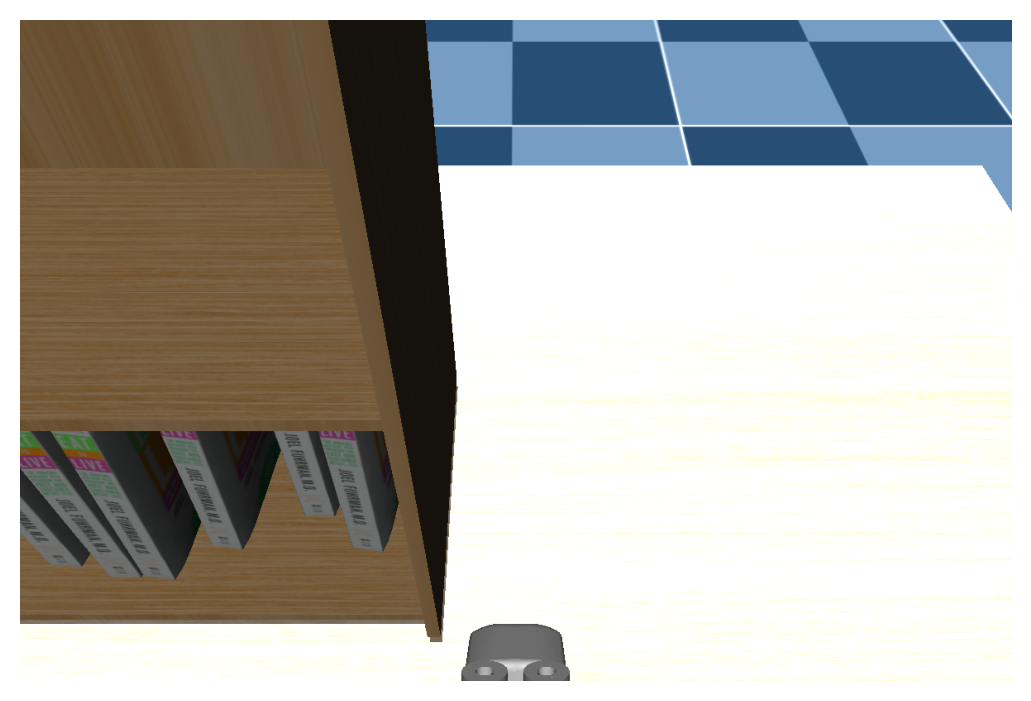

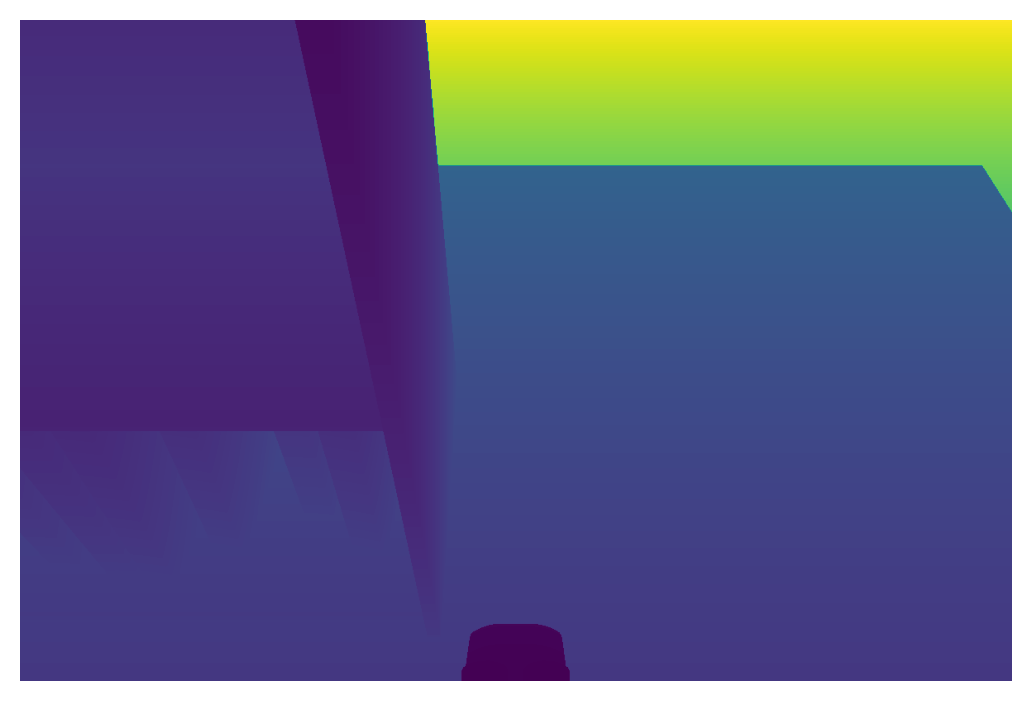

Done. Tick:[1427] Time:[2.85]sec


In [16]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0
env.reset()
exec(code_in)
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))

tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

In [17]:
env.get_p_body('book1')

array([ 0.2 , -0.4 ,  0.77])